In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor
from sklearn.preprocessing import StandardScaler

import pickle as pkl

In [2]:
# datasets = ["lungcancer", "saps", "support"]

# random_state = 2024

# parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# for dataset in datasets:

#     print("Loaded Data!")

#     X, y, groups_dict = load_dataset(dataset, include_groups = True)


#     for group in groups_dict.keys():
#         #features, labels, groups = balance_data(X, y, saps = False, groups = groups_dict[group])
#         features, labels, groups = X, y, groups_dict[group]
#         X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(features, 
#                                                             labels, 
#                                                             groups,
#                                                             test_size=0.2, 
#                                                             random_state=2024)
#         X_train = X_train
#         y_train = y_train.astype(int)
#         y_test = y_test.astype(int)

#         filepath = os.path.join(parent_dir, "data", f"{dataset}_imbalanced" , f"{dataset}_imbalanced_{group}_processed.pkl")

#         with open(filepath, 'wb') as file:
#             # Use pickle to write the dictionary to the file
#             pkl.dump([X_train, X_test, y_train, y_test, group_train, group_test] , file)

#         print("Saved Data!")

In [3]:


def load_metrics(model_type, noise_type, uncertainty_type, metric, group = "age",  dataset = 'cshock_eicu', fixed_class = None, fixed_noise = None, epsilon = 0.1, misspecify = "correct"):
    
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    
    #metrics_dir = os.path.join(parent_dir, "results", "raw", "metrics", dataset, model_type, noise_type)
    parent_dir = "/scratch/hdd001/home/snagaraj/"
    metrics_dir = os.path.join(parent_dir, "results", "metrics", dataset, model_type, noise_type, misspecify)

    # Prepare the data
    
    if uncertainty_type == "forward":
        loss_functions = ["Ours", "BCE", "forward", "backward"]
    else:
        loss_functions = ["Ours"]

    
    if ("disagreement" in metric) or ("regret" in metric):
        
        _, _, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = group)
        
        group_vec = group_test if "test" in metric else group_train
        label_vec = y_test if "test" in metric else y_train
        
        
    rows = []
    
    for loss_function in loss_functions:
        for file_name in os.listdir(metrics_dir):
            if file_name.endswith('.pkl') and uncertainty_type in file_name:
                path = os.path.join(metrics_dir, file_name)

                parts = file_name.split('_')
                
                if noise_type == "class_conditional":
                    f_class = int(parts[2])
                    f_noise = float(parts[3])
                    
                    if (f_class != fixed_class) or (f_noise != fixed_noise):
                        continue
                    
                noise = float(parts[1]) # Assumes file name format: {uncertainty}_{noise}_{epsilon}_metrics.pkl
                eps = float(parts[-2])

                if eps != epsilon:
                    continue
                
                with open(path, 'rb') as file:
                    # The noise level and uncertainty type are inferred from the file name
                    
                    metrics = pkl.load(file)

                for m in metrics.data[loss_function].keys():
                    
                    if m == metric:
                        for i, value in enumerate(metrics.data[loss_function][metric]):
                            if ("disagreement" in metric) or ("regret" in metric):
                                rows.append({
                                    'Metric': m,
                                    'Noise Level (%)': round(noise * 100),  # Assume noise is a fraction
                                    'Rate (%)': value,
                                    'Loss Function': loss_function,
                                    'Index': i,
                                    "Class": label_vec[i],
                                    f"{group}": group_vec[i]})
                
                            else:
                                rows.append({
                                    'Metric': m,
                                    'Noise Level (%)': round(noise * 100),  # Assume noise is a fraction
                                    'Rate (%)': value,
                                    'Loss Function': loss_function,
                                    'Index': i })
                

    # Scan through all files in the directory for the model_type
    
                    
    return pd.DataFrame(rows)


def run_procedure_atypical(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = "class_independent", model_type = "LR", T = None, epsilon = 0.1, misspecify = False):
    
    typical_count = 0
    preds_test = []
    preds_train = []
    
    y_vec = yn_train
    
    for seed in tqdm(range(1, max_iter+1)):
        
        u_vec = infer_u(y_vec, group = group_train, noise_type = noise_type, p_y_x_dict = p_y_x_dict,  T = T , seed=seed)
        #print(T[0,1],np.mean(u_vec))
        typical_flag, difference = is_typical(u_vec, p_y_x_dict, group = group_train,  T = T, y_vec = y_vec, noise_type = noise_type, uncertainty_type = "backward", epsilon = epsilon)

        if misspecify:
            typical_flag = True
            
        if not typical_flag:
            continue
            
        flipped_labels = flip_labels(y_vec, u_vec)
        
        model,  (train_acc,
                test_acc,
                train_probs,
                test_probs,
                train_loss,
                test_loss,
                train_preds,
                test_preds
                ) = train_model_ours(X_train, flipped_labels, X_test, y_test, seed = 2024, model_type=model_type)
        
        preds_test.append(test_preds)
        preds_train.append(train_preds)

        typical_count += 1

        if typical_count == m:
            break
            
    predictions_test = np.array(preds_test)
    disagreement_test = estimate_disagreement(predictions_test)
    ambiguity_test = calculate_error_rate(predictions_test, y_test)

    predictions_train = np.array(preds_train)
    disagreement_train = estimate_disagreement(predictions_train)
    ambiguity_train = calculate_error_rate(predictions_train, y_vec)


    return disagreement_train, disagreement_test, ambiguity_train, ambiguity_test, difference


In [23]:
model_type = "LR"
noise_type = "class_independent"

uncertainty_type = "forward"
metric = "regret_train"
dataset = "cshock_eicu"
fixed_class = 0
fixed_noise = 0
noise_level = 0.2

X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

p_y_x_dict =  calculate_prior(y_train, noise_type = noise_type, group=group_train) 

forward_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise)

forward_sub_df = forward_df[(forward_df["Loss Function"]=="Ours") & (forward_df["Noise Level (%)"]==int(noise_level*100))]

forward_values = forward_sub_df["Rate (%)"].values

true_values = ((forward_values/100)>0).astype(int)


In [24]:
m = 100
max_iter = 10000

disagreement_trains = []
disagreement_tests = []
ambiguity_trains = []
ambiguity_tests = []
shifts = []
atypicalities = []

all_metrics = []

true_u_vecs = []

for draw_id in range(5):
    _, T_true = generate_class_independent_noise(y_train, noise_level) #Fixed noise draw

    u_vec = get_u(y_train, T = T_true, seed= draw_id, noise_type = noise_type)
    true_u_vecs.append(u_vec)

    yn_train = flipped_labels = flip_labels(y_train, u_vec)

    for shift in np.linspace(0, 0.2, 10):
        T_est = adjust_transition_matrix(T_true, shift)
        #print("T est: ",T_est[0,1])
    #     (disagreement_train, 
    #     disagreement_test, 
    #     ambiguity_train, 
    #     ambiguity_test, difference) 
        outs = run_procedure_atypical(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = noise_type, model_type = model_type, T = T_est, epsilon = 0.1, misspecify = True)


        for i, metric in enumerate(["disagreement_train", "disagreement_test", 'ambiguity_train', "ambiguity_test", "atypicality"]):

            all_metrics.append({
                                "dataset": dataset,
                                "model_type": model_type,
                                "noise_type": noise_type,
                                "shift": shift,
                                #"err_method": method, #ignore err_method column for now
                                "metric": metric,
                                "value": outs[i],
                                'draw_id':draw_id
                        })

    


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:

metrics_df = pd.DataFrame(all_metrics)

#metrics_df.to_csv('typicality.csv', index=False)
#metrics_df = pd.read_csv('typicality.csv')
# Convert the 'Coverage' column from string representations of arrays to numpy arrays
#metrics_df['value'] = metrics_df['value'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))

metrics_df

,dataset,model_type,noise_type,shift,metric,value,draw_id
0,cshock_eicu,LR,class_independent,0.0,disagreement_train,"[33.09090909090909, 98.42424242424244, 91.9191...",0
1,cshock_eicu,LR,class_independent,0.0,disagreement_test,"[100.36363636363639, 77.73737373737374, 0.0, 8...",0
2,cshock_eicu,LR,class_independent,0.0,ambiguity_train,"[9.0, 42.0, 35.0, 0.0, 48.0, 0.0, 2.0, 82.0, 5...",0
3,cshock_eicu,LR,class_independent,0.0,ambiguity_test,"[46.0, 74.0, 0.0, 30.0, 0.0, 0.0, 2.0, 0.0, 10...",0
4,cshock_eicu,LR,class_independent,0.0,atypicality,0.005137,0
...,...,...,...,...,...,...,...
245,cshock_eicu,LR,class_independent,0.2,disagreement_train,"[97.73737373737376, 96.96969696969697, 100.000...",4
246,cshock_eicu,LR,class_independent,0.2,disagreement_test,"[100.36363636363639, 99.55555555555556, 83.191...",4
247,cshock_eicu,LR,class_independent,0.2,ambiguity_train,"[59.0, 60.0, 55.00000000000001, 32.0, 46.0, 28...",4
248,cshock_eicu,LR,class_independent,0.2,ambiguity_test,"[46.0, 56.00000000000001, 28.999999999999996, ...",4


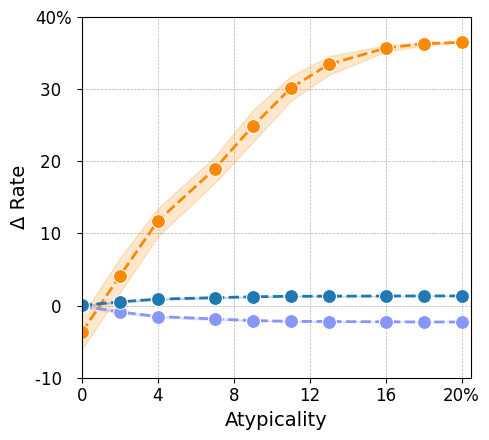

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.ticker import FuncFormatter

# Assuming `metrics_df` is already provided and `true_values` is available
# Here is the structure of `metrics_df` assumed:
# - 'dataset': The dataset name
# - 'model_type': The model type
# - 'noise_type': The noise type
# - 'shift': The shift value
# - 'metric': The metric type
# - 'value': The metric value

# Initialize lists to store accuracy, FNR, FPR, and shifts
coverage_data = []

# Calculate the baseline values at shift 0
baseline_df = metrics_df[
    (metrics_df["model_type"] == model_type) &
    (metrics_df["noise_type"] == noise_type) &
    (metrics_df["dataset"] == dataset) &
    (metrics_df["shift"] == 0)
]

baseline_ambiguity_values = np.array(baseline_df[baseline_df["metric"] == "ambiguity_train"]['value'].values[0]) / 100

baseline_predicted_labels = (baseline_ambiguity_values > 0).astype(int)
baseline_accuracy = accuracy_score(true_values, baseline_predicted_labels)
baseline_tn, baseline_fp, baseline_fn, baseline_tp = confusion_matrix(true_values, baseline_predicted_labels).ravel()
baseline_fnr = baseline_fn / (baseline_fn + baseline_tp) if (baseline_fn + baseline_tp) != 0 else 0
baseline_fpr = baseline_fp / (baseline_fp + baseline_tn) if (baseline_fp + baseline_tn) != 0 else 0
baseline_coverage = np.logical_and(true_values, baseline_predicted_labels).mean()

# Loop through each shift
for shift in metrics_df['shift'].unique():
    
    sub_df = metrics_df[
        (metrics_df["model_type"] == model_type) &
        (metrics_df["noise_type"] == noise_type) &
        (metrics_df["dataset"] == dataset) &
        (metrics_df["shift"] == shift)
    ]
    
    for i, draw_id in enumerate(range(5)):
        ambiguity_values = sub_df[(sub_df["metric"] == "ambiguity_train") & (sub_df["draw_id"] == draw_id)]['value'].values
        atypicality = sub_df[(sub_df["metric"] == "atypicality") & (sub_df["draw_id"] == draw_id)]['value'].values

        if len(ambiguity_values) > 0:
            ambiguity_values = np.array(ambiguity_values[0]) / 100
            
            if len(true_values) > 0:
                # Compute accuracy
                predicted_labels = (ambiguity_values > 0).astype(int)
                accuracy = accuracy_score(true_values, predicted_labels)
                coverage = np.logical_and(true_values, predicted_labels).mean()
                
                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(true_values, predicted_labels).ravel()
                
                # Calculate FNR and FPR
                fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
                fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
                
                # Calculate differences from baseline
                delta_coverage = (coverage - baseline_coverage) * 100
                delta_fpr = (fpr - baseline_fpr) * 100
                delta_fnr = (fnr - baseline_fnr) * 100
                
                coverage_data.append({'shift': round(shift*100), 'delta_coverage': delta_coverage, 'delta_fpr': delta_fpr, 'delta_fnr': delta_fnr, 'draw_id': draw_id, 'atypicality': atypicality})

# Convert accuracy data to a DataFrame
coverage_df = pd.DataFrame(coverage_data)

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Plot delta FPR
sns.lineplot(ax=ax, data=coverage_df, x='shift', y='delta_fnr',  marker='o', markersize=10, linestyle='--', linewidth=2, color = "#8896FB")

# Plot delta FPR
sns.lineplot(ax=ax, data=coverage_df, x='shift', y='delta_fpr',  marker='o', markersize=10, linestyle='--', linewidth=2, color = "#fc8803")

# Plot delta Coverage
sns.lineplot(ax=ax, data=coverage_df, x='shift', y='delta_coverage', marker='o', markersize=10, linestyle='--', linewidth=2)

# Customize the plot
ax.set_xlim(0,20.5)
ax.set_ylim(-10,40)
ax.set_xlabel('Atypicality', size=14)
ax.set_ylabel('Δ Rate', size=14)
num_x_ticks = 6
num_y_ticks = 6
# Formatter to display integer ticks on x-axis
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


ax.set_xticks(np.linspace(0, 20, num_x_ticks))
ax.set_yticks(np.linspace(-10, 40, num_y_ticks))

ax.set_xticklabels([str(int(x)) + '%' if x== 20 else str(int(x)) for x in ax.get_xticks()])
ax.set_yticklabels([str(int(y)) + '%' if y == 40 else str(int(y))+"  " for y in ax.get_yticks()])





ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("atypicality.pdf", bbox_inches='tight')
plt.show()
